# Almacenamiento de Agua

Importar librerías a usar.

- Numpy
- ee: API de Google Earth Engine
- folium: visualización de mapas sobre Leaflet

In [2]:
import numpy as np
import ee
import folium
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.preprocessing import StandardScaler

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

from matplotlib import pyplot as plt

Inicializar sesión de Google Earth Engine

In [3]:
ee.Initialize()

Parámetros de visualización (composición de bandas) para Sentinel-2

In [4]:
visRGB = {"bands": ["B4","B3","B2"],"min":0,"max":2000}
visRGBref = {"bands": ["B4","B3","B2"],"min":0,"max":0.2}
visRGB_water = {"bands": ["B4","B3","B2"],"min":0,"max":800}
visIndex = {"min":0,"max":1}

## Datos iniciales

### Fecha

- interestDate: Fecha deseada para la cual se desea calcular el volumen de agua almacenada.
- deltaDays: Rango de fechas para buscar imágenes adicionales +/- la fecha de interés.

In [5]:
interestDate = "2019-10-22"
deltaDays = 4

### Región

- xmin: longitud mínima.
- xmax: longitud máxima.
- ymin: latitud mínima.
- ymax: latitud máxima.

In [6]:
xmin = -8.22603391725042
ymin = 41.85962828770244
xmax = -8.063298931898858
ymax = 41.93092895284894

In [7]:
centerx = np.array([xmin,xmax]).mean()
centery = np.array([ymin,ymax]).mean()

In [8]:
ROI = ee.Geometry.Rectangle([xmin,ymin,xmax,ymax])

## Funciones

### 1. Visualización de una imagen en Folium

In [9]:
def foliumLayer(image,parameters = visRGB,layer_name = "layer"):
    
    folium_map = folium.Map(location = [centery,centerx],zoom_start = 13)
    
    mapIdDict = image.getMapId(parameters) # convertir imagen a id de visualizacion
    
    tile = folium.TileLayer(tiles = mapIdDict['tile_fetcher'].url_format,
                            attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
                            overlay = True,
                            name = layer_name)
    
    tile.add_to(folium_map)
    
    folium_map.add_child(folium.LayerControl())
    
    return folium_map

### 2. Cortar imágenes por ROI

In [10]:
def clip_images(image):
        
    return image.clip(ROI).copyProperties(image,["system:time_start"]) # retornar imagenes recortadas

### 3. Enmascarar nubes y sombras de una imagen

In [11]:
def clouds_shadows_mask(image):
    
    shadows_mask = image.select('SCL').eq(3).Not() # pixeles que no son sombra
    clouds_mask = image.select('SCL').lt(7).Or(image.select('SCL').gt(9)) # pixeles que no son nubes
    mask = shadows_mask.And(clouds_mask) # pixeles que no son ni sombra ni nubes
    
    return image.updateMask(mask).copyProperties(image,["system:time_start"]) # retornar imagenes enmascaradas

### 4. Seleccionar imágenes

In [12]:
def collectS2Images(interestDate,deltaDays,xmin,ymin,xmax,ymax,clipImages = True):
    
    ROI = ee.Geometry.Rectangle([xmin,ymin,xmax,ymax])
    
    interestDate = np.datetime64(interestDate)
    initialDate = np.datetime_as_string(interestDate - np.timedelta64(deltaDays,'D'))
    finalDate = np.datetime_as_string(interestDate + np.timedelta64(deltaDays,'D'))
    
    IC = ee.ImageCollection("COPERNICUS/S2_SR").filterDate(initialDate,finalDate).filterBounds(ROI)
    
    if clipImages:
        
        def clip_images(image):        
            return image.clip(ROI).copyProperties(image,["system:time_start"]) # retornar imagenes recortadas
        
        IC = IC.map(clip_images)
    
    return IC

### 5. Calcular Reflectancia

In [13]:
def reflectance(image):
        
    return ee.Image(image.multiply(0.0001).copyProperties(image,["system:time_start"]))

### 6. Máscara de agua automática

In [14]:
def automaticWaterMask(image,ROI,index = "GNDVI",seedSpacing = 20,gridType = "square",compactness = 1,connectivity = 8,scale = 10,k = 3):

    print("Iniciando cálculo de máscara de agua...")
    
    print("******************************")
    print("Creando índice")
    if index == "GNDVI":
        idx = image.normalizedDifference(['B8','B3'])
    elif index == "NDWI":
        idx = image.normalizedDifference(['B3','B8'])

    print("Segmentando imagen")
    seeds = ee.Algorithms.Image.Segmentation.seedGrid(seedSpacing,gridType)
    SNIC = ee.Algorithms.Image.Segmentation.SNIC(image = ee.Image.cat([image.select(['B2','B3','B4','B8']),idx]),                                             
                                                 compactness = compactness,
                                                 connectivity = 8,                                                 
                                                 seeds = seeds)
    SNIC = SNIC.select(['B2_mean','B3_mean','B4_mean','B8_mean','nd_mean','clusters'], ['B2','B3','B4','B8','idx','clusters'])

    print("Cluterizando imagen segmentada")
    objectPropertiesImage = SNIC.select(['B2','B3','B4','B8','idx'])
    X_train = objectPropertiesImage.sample(scale = scale,numPixels = 5000,region = ROI)
    kmeans = ee.Clusterer.wekaKMeans(k)
    kmeans = kmeans.train(X_train)
    clusterImage = objectPropertiesImage.cluster(kmeans)

    print("Determinando clúster de agua")
    values = []
    for i in range(k):
        cluster_mask = clusterImage.eq(i)
        idx_clusterMasked = idx.updateMask(cluster_mask)
        mean_value = idx_clusterMasked.reduceRegion(reducer = ee.Reducer.mean(),geometry = ROI,scale = 50)
        values.append(mean_value.getInfo()['nd'])
        print("---> Avance:",round((i+1)*100/(k),2),"% <---")
    cluster_water = np.array(values).argmin().item()

    print("Proceso finalizado")
    water_mask = clusterImage.eq(cluster_water)
    
    return water_mask

### 7. Crear Costo Acumulado

In [15]:
def depthCumulativeCost(waterMask,ROI,scale = 10,maxDistance = 1000):

    water_poly = waterMask.reduceToVectors(geometry = ROI,scale = scale,eightConnected = False)
    water_poly = water_poly.filter(ee.Filter.eq('label',1))

    coords = water_poly.geometry().coordinates().getInfo()
    lines = []
    for i in range(len(coords)):
        for j in range(len(coords[i])):
            lines.append(ee.Geometry.LineString(coords[i][j]))

    allLines = ee.FeatureCollection(lines)

    sources = ee.Image().toByte().paint(allLines, 1)
    sources = sources.updateMask(sources)

    cumulativeCost = waterMask.cumulativeCost(source = sources,maxDistance = maxDistance).updateMask(waterMask)
    
    return cumulativeCost

### 8. Leer Batimetría

In [28]:
def loadBathymetry(filePath,delimeter = "\t",usecols = (2,3,5),startLine = 7):

    f = open(filePath)
    textList = f.readlines()[startLine:]

    outF = open("bathyTemp.txt","w")
    for line in textList:
        line = line.replace(",",".")
        outF.write(line)    
    outF.close()

    bathy = np.loadtxt("bathyTemp.txt",delimiter = delimeter,usecols = usecols)
    
    return bathy

### 9. Extraer datos de las imágenes

In [33]:
def pixelDataFromCoordinates(image,coords,coordsCols = [0,1],batchSize = 5000,scale = 10,joinData = True,toPandas = True):
    
    extractedData = []

    k = 0

    print("Comenzando la extracción de datos...")
    while k <= coords.shape[0]:

        print("******************************")
        print("Creando nuevo batch...")
        pointFeatures = []

        initial = k
        print("Inicia en",initial)

        if k + batchSize > coords.shape[0]:
            final = coords.shape[0]
        else:
            final = k + batchSize
        print("Finaliza en",final)

        print("Realizando extracción...")
        for i in range(initial,final):
            pointFeatures.append(ee.Geometry.Point([coords[i,coordsCols[0]],coords[i,coordsCols[1]]]))

        fromList = ee.FeatureCollection(pointFeatures)

        imageDictionary = image.reduceRegions(collection = fromList,reducer = ee.Reducer.first(),scale = scale)

        features = imageDictionary.getInfo()['features']

        for i in range(len(features)):
            extractedData.append(list(features[i]['properties'].values()))

        print("Extracción finalizada")
        print("---> Avance:",round(final*100/coords.shape[0],1),"% <---")

        k = k + batchSize
    
    if joinData:
        extractedData = np.concatenate((coords,np.array(extractedData)),axis = 1)
    
    if toPandas:
        extractedData = pd.DataFrame(extractedData)
    
    return extractedData

## Paso 1. Seleccionar imágenes

In [16]:
S2 = collectS2Images(interestDate,deltaDays,xmin,ymin,xmax,ymax)

In [17]:
foliumLayer(S2.first(),layer_name = "Imagen sin mascara")

## Paso 2. Enmascarar nubes y sombras

In [18]:
S2_masked = S2.map(clouds_shadows_mask)

In [19]:
foliumLayer(S2_masked.first(),layer_name = "Imagen con mascara")

## Paso 3. Reducir imagen

In [20]:
S2_reduced = reflectance(S2_masked.median())

In [21]:
foliumLayer(S2_reduced,visRGBref,layer_name = "Imagen reducida")

## PASO DE PRUEBA: AUTOMATIC WATER MASK

In [22]:
water_mask = automaticWaterMask(S2_reduced,ROI)

Iniciando cálculo de máscara de agua...
******************************
Creando índice
Segmentando imagen
Cluterizando imagen segmentada
Determinando clúster de agua
---> Avance: 33.33 % <---
---> Avance: 66.67 % <---
---> Avance: 100.0 % <---
Proceso finalizado


In [23]:
foliumLayer(water_mask,{},"WM")

## PASO DE PRUEBA: CUMULATIVE COST

In [25]:
cumulativeCost = depthCumulativeCost(water_mask,ROI)

In [26]:
foliumLayer(cumulativeCost,{"min":0,"max":400},"CumCost")

In [29]:
bathy = loadBathymetry("C:/Users/Dave Mont/Desktop/Master_of_DataScience/TFM/bathymetric_data")

In [36]:
water = S2_reduced.updateMask(water_mask)
water = water.addBands(water.pixelLonLat())
water = water.addBands(cumulativeCost)

In [37]:
water.bandNames().getInfo()

['B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B9',
 'B11',
 'B12',
 'AOT',
 'WVP',
 'SCL',
 'TCI_R',
 'TCI_G',
 'TCI_B',
 'MSK_CLDPRB',
 'MSK_SNWPRB',
 'QA10',
 'QA20',
 'QA60',
 'longitude',
 'latitude',
 'cumulative_cost']

In [38]:
imageToReduce = water.select(['B2','B3','B4','B8','longitude','latitude','cumulative_cost'])

In [39]:
data = pixelDataFromCoordinates(imageToReduce,bathy)
pd.set_option("display.precision",15)
data.columns = ['BatLon','BatLat','Profundidad','B2','B3','B4','B8','CumCost','PixLat','PixLon']
data

Comenzando la extracción de datos...
******************************
Creando nuevo batch...
Inicia en 0
Finaliza en 5000
Realizando extracción...
Extracción finalizada
---> Avance: 29.7 % <---
******************************
Creando nuevo batch...
Inicia en 5000
Finaliza en 10000
Realizando extracción...
Extracción finalizada
---> Avance: 59.4 % <---
******************************
Creando nuevo batch...
Inicia en 10000
Finaliza en 15000
Realizando extracción...
Extracción finalizada
---> Avance: 89.1 % <---
******************************
Creando nuevo batch...
Inicia en 15000
Finaliza en 16844
Realizando extracción...
Extracción finalizada
---> Avance: 100.0 % <---


,BatLon,BatLat,Profundidad,B2,B3,B4,B8,CumCost,PixLat,PixLon
0,-8.0842824,41.9206111,6.5,0.0104,0.0225,0.0164,0.0205,6.23225766788888,41.920646301429,-8.08425365214102
1,-8.0842825,41.9206113,6.5,0.0104,0.0225,0.0164,0.0205,6.23225766788888,41.920646301429,-8.08425365214102
2,-8.0842826,41.9206113,6.5,0.0104,0.0225,0.0164,0.0205,6.23225766788888,41.920646301429,-8.08425365214102
3,-8.0842829,41.9206113,6.6,0.0104,0.0225,0.0164,0.0205,6.23225766788888,41.920646301429,-8.08425365214102
4,-8.0842832,41.9206113,6.7,0.0104,0.0225,0.0164,0.0205,6.23225766788888,41.920646301429,-8.08425365214102
...,...,...,...,...,...,...,...,...,...,...
16839,-8.0842505,41.920655,7,0.0104,0.0225,0.0164,0.0205,6.23225766786692,41.920646301429,-8.08425365214102
16840,-8.0842365,41.920659,7.3,0.0104,0.0225,0.0164,0.0205,6.23225766786692,41.920646301429,-8.08425365214102
16841,-8.0842241,41.9206626,7.2,0.0104,0.0225,0.0164,0.0205,6.23225766786692,41.920646301429,-8.08425365214102
16842,-8.0842154,41.920665,7.2,0.0104,0.0225,0.0164,0.0205,6.23225766786692,41.920646301429,-8.08425365214102


In [44]:
newPdData = pdData.astype({'BatLon':'float64',
                          'BatLat':'float64',
                          'Profundidad':'float64',
                          'B2':'float64',
                          'B3':'float64',
                          'B4':'float64',
                          'B8':'float64',
                          'CumCost':'float64'}).dropna()

In [45]:
dataMeans = newPdData.groupby(['PixLat','PixLon']).mean()
dataStd = newPdData.groupby(['PixLat','PixLon']).std()
dataCount = newPdData.groupby(['PixLat','PixLon']).count()

In [46]:
dataMeans

BatLon              BatLat  \
PixLat             PixLon                                                      
41.869172835648925 -8.183966648678282 -8.183925400000000  41.869217399999997   
                   -8.183876817149871 -8.183876966666666  41.869184799999999   
                   -8.183786985621458 -8.183794550000000  41.869164400000003   
                   -8.183697154093046 -8.183706800000001  41.869162833333327   
                   -8.183607322564635 -8.183602733333332  41.869162166666662   
...                                                  ...                 ...   
41.922892089639269 -8.081199380175009 -8.081225733333333  41.922929916666668   
                   -8.081109548646598 -8.081075200000001  41.922935899999999   
                   -8.081019717118185 -8.081040320000000  41.922906920000003   
41.922981921167683 -8.081199380175009 -8.081182387500000  41.922943937500001   
                   -8.081109548646598 -8.081118981818182  41.922946490909091   

                                              Profundidad      B2      B3  \
PixLat             PixLon                                                   
41.869172835648925 -8.183966648678282  26.399999999999999  0.0041  0.0061   
                   -8.183876817149871  25.333333333333332  0.0041  0.0061   
                   -8.183786985621458  25.799999999999997  0.0025  0.0063   
                   -8.183697154093046  27.500000000000000  0.0025  0.0079   
                   -8.183607322564635  26.566666666666666  0.0040  0.0061   
...                                                   ...     ...     ...   
41.922892089639269 -8.081199380175009   7.033333333333334  0.0063  0.0157   
                   -8.081109548646598   7.200000000000000  0.0051  0.0143   
                   -8.081019717118185   7.300000000000000  0.0051  0.0143   
41.922981921167683 -8.081199380175009   7.825000000000001  0.0066  0.0174   
                   -8.081109548646598   7.581818181818182  0.0068  0.0176   

                                           B4      B8              CumCost  
PixLat             PixLon                                                   
41.869172835648925 -8.183966648678282  0.0048  0.0069   86.935068397281555  
                   -8.183876817149871  0.0048  0.0069   94.381765494088015  
                   -8.183786985621458  0.0032  0.0058  101.828462590894446  
                   -8.183697154093046  0.0048  0.0051  104.253905856628762  
                   -8.183607322564635  0.0037  0.0058   96.807198295440983  
...                                       ...     ...                  ...  
41.922892089639269 -8.081199380175009  0.0139  0.0125   32.464346503966290  
                   -8.081109548646598  0.0139  0.0102   30.000000000389591  
                   -8.081019717118185  0.0139  0.0102   28.696526008808178  
41.922981921167683 -8.081199380175009  0.0159  0.0159   22.464346503836424  
                   -8.081109548646598  0.0156  0.0151   20.000000000259725  

[5886 rows x 8 columns]

(array([2.898e+03, 1.747e+03, 7.820e+02, 2.360e+02, 1.170e+02, 4.800e+01,
        3.700e+01, 5.000e+00, 4.000e+00, 2.000e+00, 1.000e+00, 3.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1.  ,  2.15,  3.3 ,  4.45,  5.6 ,  6.75,  7.9 ,  9.05, 10.2 ,
        11.35, 12.5 , 13.65, 14.8 , 15.95, 17.1 , 18.25, 19.4 , 20.55,
        21.7 , 22.85, 24.  , 25.15, 26.3 , 27.45, 28.6 , 29.75, 30.9 ,
        32.05, 33.2 , 34.35, 35.5 , 36.65, 37.8 , 38.95, 40.1 , 41.25,
        42.4 , 43.55, 44.7 , 45.85, 47.  ]),
 <a list of 40 Patch objects>)

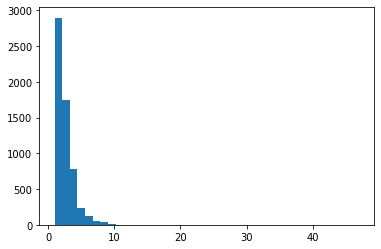

In [162]:
plt.hist(dataCount['Profundidad'],bins = 40)

{'whiskers': [<matplotlib.lines.Line2D at 0x2588a067f48>,
 'caps': [<matplotlib.lines.Line2D at 0x2588a06bfc8>,
 'boxes': [<matplotlib.lines.Line2D at 0x2588a067688>],
 'medians': [<matplotlib.lines.Line2D at 0x2588a06ef88>],
 'fliers': [<matplotlib.lines.Line2D at 0x2588a06ef08>],
 'means': []}

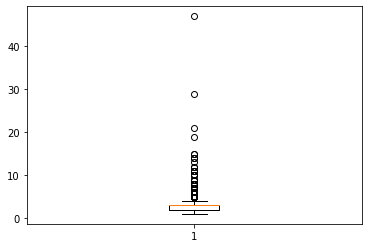

In [163]:
plt.boxplot(dataCount['Profundidad'])

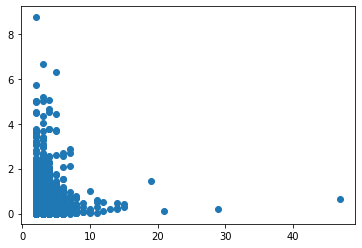

In [164]:
plt.scatter(dataCount['Profundidad'],dataStd['Profundidad'])

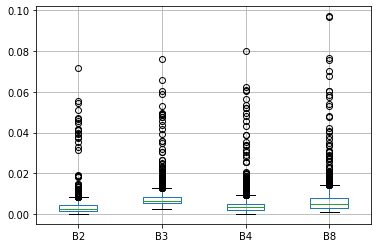

In [167]:
dataMeans.boxplot(column = ['B2','B3','B4','B8'])

### Modelo Lineal (Usando la Razón Logarítmica (B2/B3))

Precisión del modelo: 0.03 (+/- 0.01)
RMSE: 13.697024909551967
R2: 0.0250575090236409


Text(0, 0.5, 'Real')

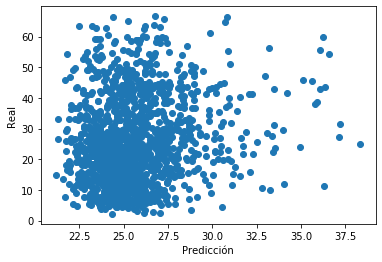

In [173]:
X = np.array(np.log(dataMeans['B2'])/np.log(dataMeans['B3']))
y = dataMeans['Profundidad']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25,random_state=42)

reg = LinearRegression().fit(X_train.reshape(-1, 1),y_train)

scores = cross_val_score(LinearRegression(),X_train.reshape(-1, 1),y_train,cv = 5)
print("Precisión del modelo: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

y_pred = reg.predict(X_test.reshape(-1, 1))

print("RMSE:",mse(y_test,y_pred,squared = False))
print("R2:",r2(y_test,y_pred))

plt.scatter(y_pred,y_test)
plt.xlabel("Predicción")
plt.ylabel("Real")

### Modelo lineal (Usando las cuatro bandas)

Precisión del modelo: 0.22 (+/- 0.15)
RMSE: 11.77574088247486
R2: 0.279385512654143


Text(0, 0.5, 'Real')

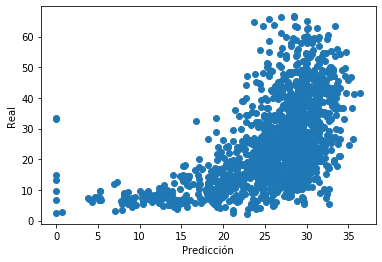

In [174]:
X = dataMeans[['B2','B3','B4','B8']]
y = dataMeans['Profundidad']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25,random_state=42)

scores = cross_val_score(LinearRegression(),X_train,y_train,cv = 10)
print("Precisión del modelo: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

reg = LinearRegression().fit(X_train,y_train)
y_pred = reg.predict(X_test)
y_pred[y_pred < 0] = 0

print("RMSE:",mse(y_test,y_pred,squared = False))
print("R2:",r2(y_test,y_pred))

plt.scatter(y_pred,y_test)
plt.xlabel("Predicción")
plt.ylabel("Real")

### Modelo de Procesos Gausianos (Usando las cuatro bandas)

GPML kernel: 18.7**2 * RBF(length_scale=0.0133) + WhiteKernel(noise_level=115)
Log-marginal-likelihood: -16767.272
RMSE: 10.408378823222058
R2: 0.43702036081140094


Text(0, 0.5, 'Real')

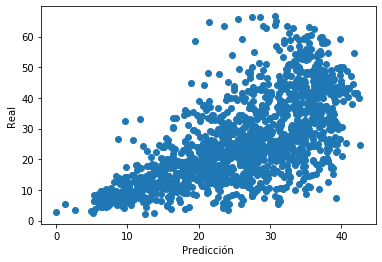

In [175]:
gp_kernel = C(1.0,(1e-4, 1e4)) * RBF(1,(1e-4, 1e4)) + WhiteKernel(1,(1e-4,1e4))
gp = GaussianProcessRegressor(kernel=gp_kernel,n_restarts_optimizer=10)

gp.fit(X_train,y_train)

print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f" % gp.log_marginal_likelihood(gp.kernel_.theta))

y_pred,sigma = gp.predict(X_test,return_std=True)
y_pred[y_pred < 0] = 0

print("RMSE:",mse(y_test,y_pred,squared = False))
print("R2:",r2(y_test,y_pred))

plt.scatter(y_pred,y_test)
plt.xlabel("Predicción")
plt.ylabel("Real")

### Usando CumulativeCost

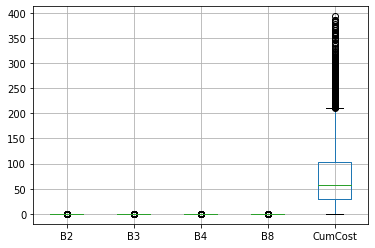

In [207]:
dataMeans.boxplot(column = ['B2','B3','B4','B8','CumCost'])

In [47]:
X = dataMeans[['B2','B3','B4','B8','CumCost']]
y = dataMeans['Profundidad']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25,random_state=42)

scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Precisión del modelo: 0.40 (+/- 0.06)
RMSE: 10.714975871032392
R2: 0.4033647584495905


Text(0, 0.5, 'Real')

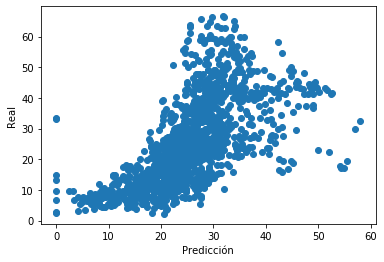

In [48]:
scores = cross_val_score(LinearRegression(),X_train_scaled,y_train,cv = 10)
print("Precisión del modelo: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

reg = LinearRegression().fit(X_train_scaled,y_train)
y_pred = reg.predict(X_test_scaled)
y_pred[y_pred < 0] = 0

print("RMSE:",mse(y_test,y_pred,squared = False))
print("R2:",r2(y_test,y_pred))

plt.scatter(y_pred,y_test)
plt.xlabel("Predicción")
plt.ylabel("Real")

GPML kernel: 15.2**2 * RBF(length_scale=1.73) + WhiteKernel(noise_level=86.3)
Log-marginal-likelihood: -16195.756
RMSE: 9.154728111399873
R2: 0.5644706684146985


Text(0, 0.5, 'Real')

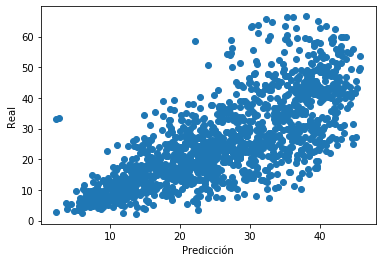

In [49]:
gp_kernel = C(1.0,(1e-4, 1e4)) * RBF(1,(1e-4, 1e4)) + WhiteKernel(1,(1e-4,1e4))
gp = GaussianProcessRegressor(kernel=gp_kernel,n_restarts_optimizer=10)

gp.fit(X_train_scaled,y_train)

print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f" % gp.log_marginal_likelihood(gp.kernel_.theta))

y_pred,sigma = gp.predict(X_test_scaled,return_std=True)
y_pred[y_pred < 0] = 0

print("RMSE:",mse(y_test,y_pred,squared = False))
print("R2:",r2(y_test,y_pred))

plt.scatter(y_pred,y_test)
plt.xlabel("Predicción")
plt.ylabel("Real")

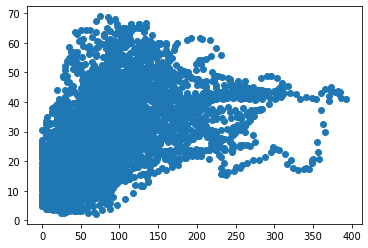

In [51]:
the_x = (dataMeans['CumCost']/dataMeans['B3'])

plt.scatter(dataMeans['CumCost'],dataMeans['Profundidad'])

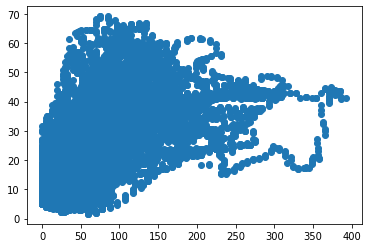

In [104]:
plt.scatter(pdData['CumCost'],pdData['Profundidad'])

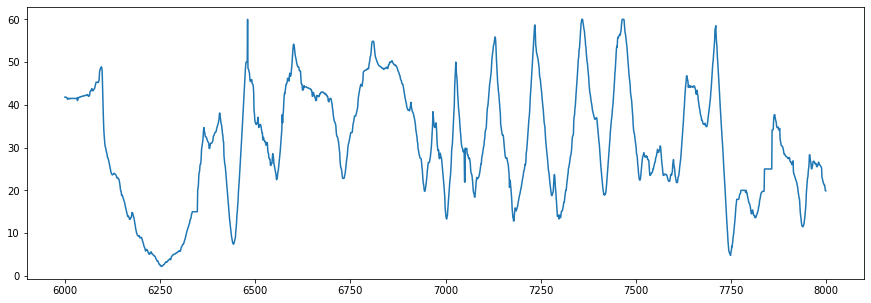

In [103]:
plt.figure(figsize=(15,5))
n = 6000
k = 8000
plt.plot(range(n,k),pdData['Profundidad'].iloc[n:k])
#plt.plot(range(n),pdData['Profundidad'].iloc[:n].rolling(10,center = True).mean())
#plt.plot(range(n),pdData['Profundidad'].iloc[:n].rolling(20,center = True).mean())
#plt.plot(range(n),pdData['Profundidad'].iloc[:n].rolling(30,center = True).mean())

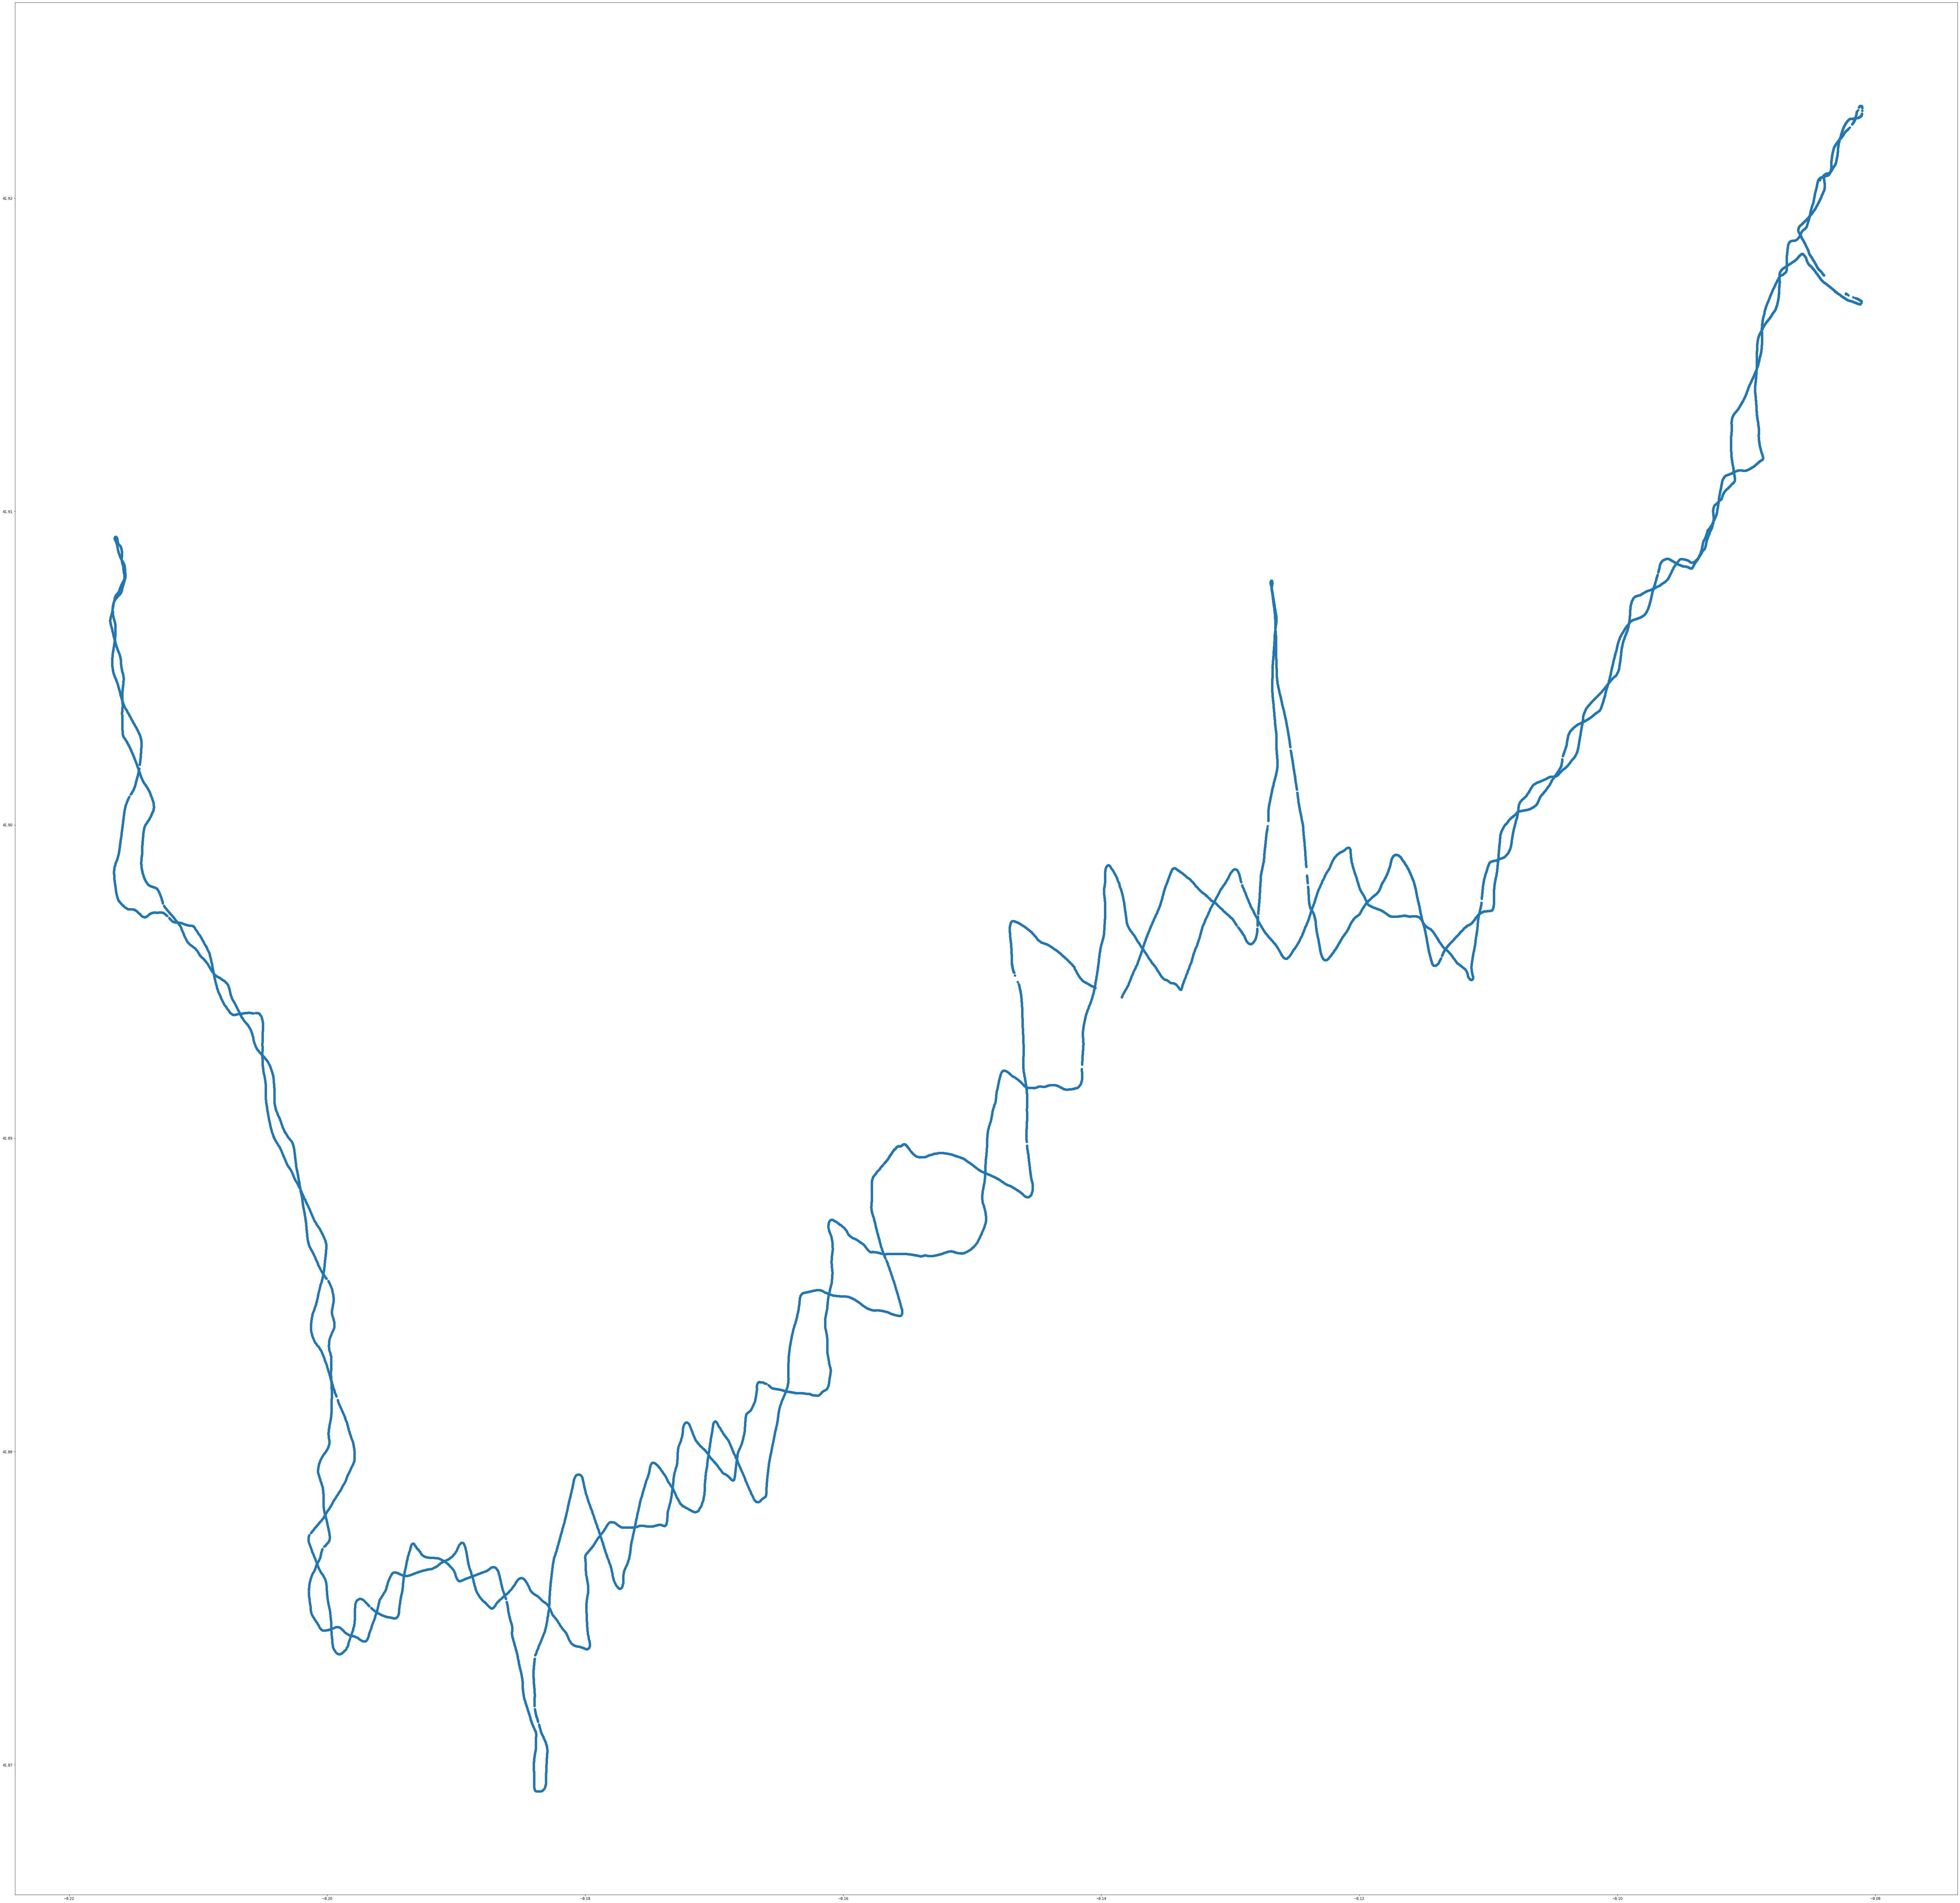

In [65]:
plt.figure(figsize=(120,100))
plt.scatter(pdData['BatLon'],pdData['BatLat'])